In [4]:
#Add libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [5]:
#Load data processed on the HPC

prs = pd.read_csv("../data/protein_prs_cases.csv", sep="\t", index_col=0)

prs.head()

,Group,Case,Sex,C4A.C4B.4481.34.2,IL10.2773.50.2,MMP9.2579.17.5,CSF3.8952.65.3,GC.6581.50.3,APOB.2797.56.2,CFH.4159.130.1,...,C3.2755.8.2,PPY.4588.1.2,IGFBP2.2570.72.5,APOE.2937.10.2,FGA.FGB.FGG.4907.56.1,PLG.3710.49.2,TNF.5936.53.3,ANGPT2.13660.76.3,CRP.4337.49.2,VCAM1.2967.8.1
0,A,2,2,-0.069435,-0.034924,-0.126787,0.351996,0.314848,-0.318171,0.195647,...,0.057947,0.749855,0.146249,-0.133883,-2.490502,-0.324963,-0.978661,0.039893,-0.266216,-0.038887
1,A,2,2,-1.071661,-0.421213,-0.872182,0.101832,-0.296282,0.689710,-0.409555,...,-0.903393,0.306309,-1.152134,0.421410,0.405951,0.950770,1.549364,1.410669,-1.659654,2.214628
2,A,2,1,0.321382,-2.000421,-0.126787,0.207792,0.952631,-2.252077,-1.264962,...,1.754089,1.248028,1.187176,-1.003851,-0.848056,-0.324963,-1.076009,0.381713,-0.420168,-0.413070
3,A,2,2,0.575056,-0.256073,0.618608,-1.863235,-0.379302,0.689710,-0.636036,...,-1.259195,-0.329593,-0.662532,-0.133883,1.754016,0.614542,-1.708552,-1.134225,-1.053209,-0.110263
4,A,2,2,1.512781,0.417969,-0.126787,0.091216,-0.337681,-0.318171,-0.115083,...,0.554612,-0.582945,0.512406,0.843965,0.379672,-1.239034,0.858960,-0.683777,-0.344878,-0.487496


In [6]:
#Update case and sex from 2/1 and to dummy variables 1/0
#Case -> 1 = "AD", 0 = "CTL"
#Sex -> 1 = "Female", 0 = "Male"

if (prs["Case"].max() == 2) | (prs["Sex"].max() == 2):
    prs.loc[prs["Case"] == 1, "Case"] = 0
    prs.loc[prs["Case"] == 2, "Case"] = 1

    prs.loc[prs["Sex"] == 1, "Sex"] = 0
    prs.loc[prs["Sex"] == 2, "Sex"] = 1
else:
    print("Already updated")

print(prs[["Case", "Sex"]].describe())

print(prs.groupby("Group")["Case"].sum())

              Case          Sex
count  6244.000000  6244.000000
mean      0.686579     0.598334
std       0.463921     0.490274
min       0.000000     0.000000
25%       0.000000     0.000000
50%       1.000000     1.000000
75%       1.000000     1.000000
max       1.000000     1.000000
Group
A    3277
B     639
C     371
Name: Case, dtype: int64


In [7]:
#METHOD TO PREPARE RESULTS (ADJUST FOR RANDOM FOREST INPUTS)
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix

def assess_model_performance(md, pred, X_test, y_test, estimator, feature, model_name, plot=True):
    accuracy_sk = md.score(X_test, y_test)
    auc = roc_auc_score(y_test, md.predict(X_test))
    tn, fp, fn, tp = confusion_matrix(y_test, pred).ravel()
    sensitivity = tp / (tp + fn) #-> also recall
    specificity = tn / (tn + fp)
    precision = tp / (tp + fp)
    
    result = pd.DataFrame({"model_name":model_name, 
                           "n_estimators":estimators,
                           "max_features":features,
                           "accuracy":accuracy_sk, 
                           "sensitivity": sensitivity, 
                           "specificity":specificity,
                           "precision":precision,
                           "auc":auc}, index=[1])
    
    if plot:
        probas = md.predict_proba(X_test)
        plt.plot(roc_curve(y_test, probas[:,1])[0], roc_curve(y_test, probas[:,1])[1], label=model_name)
        plt.xlabel("FPR")
        plt.ylabel("TPR")
        plt.legend(prop={'size':10}, loc='lower right')
    
    return result

Feature Importance -> 10-None [0.03497783 0.03093501 0.02172308 0.0342747  0.04084879 0.0967532
 0.02991322 0.03127823 0.02803497 0.02970128 0.03468011 0.03666767
 0.02813985 0.03850702 0.02972466 0.03604993 0.02803733 0.03024012
 0.03086263 0.03075524 0.02732632 0.03145214 0.02492932 0.02826691
 0.01954855 0.03499844 0.02673219 0.02459487 0.02989751 0.02264861
 0.02750027]
Feature Importance -> 10-auto [0.03428069 0.03084823 0.02660422 0.03379292 0.03271358 0.0571886
 0.03408062 0.02864361 0.03245332 0.02786902 0.03649557 0.0346256
 0.03017623 0.03741934 0.02885676 0.03115058 0.03386798 0.03334304
 0.03310885 0.03304355 0.02590677 0.03427325 0.02584831 0.02843006
 0.031629   0.02760768 0.02773271 0.02860153 0.03003666 0.04285263
 0.02651909]
Feature Importance -> 10-log2 [0.03136919 0.03261701 0.02669011 0.02759716 0.03657017 0.05244092
 0.03141642 0.03461331 0.03603379 0.03642127 0.03373375 0.03310705
 0.02766331 0.03305524 0.03090598 0.02810534 0.03610613 0.02859891
 0.03088653 0.03

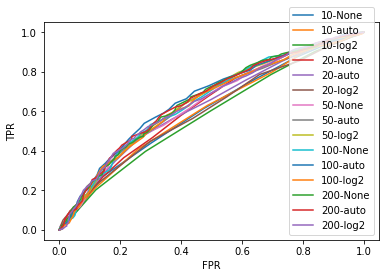

In [9]:
#Random Forest Classifier tested with combination of hyperparameters for n_estimators and max_features
    #Decided against testing range of hyperparameters for max_depth, min_samples_split and min_samples_left as computation time was acceptable given moderate number of dimensions
    
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

PROTEIN_DATA = prs.iloc[:, 3:]
RESULTS = pd.DataFrame()

#Split data into training and hold-out test
x_train, x_test, y_train, y_test = train_test_split(PROTEIN_DATA, prs["Case"], test_size=0.25, random_state=0)

estimators_test_range = [10, 20, 50, 100, 200]
#“auto” -> max_features=sqrt(n_features).
max_features_range = [None, "auto", "log2"]

for estimators in estimators_test_range:
    for features in max_features_range:
        clf = RandomForestClassifier(n_estimators=estimators, max_features=features)
        md = clf.fit(x_train, y_train)

        pred = md.predict(x_test)
        
        model_name = str(estimators) + "-" + str(features)
        
        #Print feature importances
        print("Feature Importance ->", model_name, md.feature_importances_)
        
        result = assess_model_performance(md, pred, x_test, y_test, estimators, features, model_name)

        RESULTS = RESULTS.append(result, ignore_index = True)

RESULTS.sort_values(by="auc", ascending=False, inplace=True)
print(RESULTS)

#Findings
    #On average, AUC improves with the most performant model presenting an AUC of 0.575 (vs ~0.537-8 using logistic regression methods).
    #However, the cost is accuracy which is marginally lower. This is due to reduced sensitivity and higher specificity (Random Forest appears better at classifying true negatives)